In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/'My Drive'/Diploma/SemanticNYU/

/content/gdrive/My Drive/Diploma/SemanticNYU


In [3]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp
import os
import warnings
import cv2
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
import torch.nn as nn
from io import BytesIO
from zipfile import ZipFile
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

     |████████████████████████████████| 71kB 2.7MB/s 
     |████████████████████████████████| 245kB 4.9MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=698d1517380dd43df077f408142a5aa4484a39d605cd7f00a11d52ea3267f4f3
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=5848dada163dc158ebd08d646c888c8cf787035e540de6e79d8de22a82ba5212
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built pretrainedmodels efficientnet-pytorch


In [4]:
def load_zip(zip_file, test = False):
    print('Loading dataset zip file...', end='')
    input_zip = ZipFile(zip_file)
    data = {name: input_zip.read(name) for name in input_zip.namelist()}
    return data

In [5]:
#TRAIN_DIR = "data/train_images/"
#VAL_DIR = "data/val_images/"
TRAIN_LIST = "data/train.nyu"
VAL_LIST = "data/val.nyu"
SHORTER_SIDE = 480
CROP_SIZE = 640
NORMALISE_PARAMS = [
    1.0 / 255,  # SCALE
    np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3)),  # MEAN
    np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3)),
]  # STD
BATCH_SIZE = 14
NUM_WORKERS = 16
NUM_CLASSES = 40
LOW_SCALE = 0.5
HIGH_SCALE = 2.0
IGNORE_LABEL = 255

In [6]:
class NYUDataset(Dataset):
    def __init__(self, data_file, data, transform_trn=None, transform_val=None):
        with open(data_file, "rb") as f:
            datalist = f.readlines()
        self.datalist = [
            (k, v)
            for k, v in map(
                lambda x: x.decode("utf-8").strip("\n").split("\t"), datalist
            )
        ]
        self.data = data
        self.transform_trn = transform_trn
        self.transform_val = transform_val
        self.stage = "train"

    def set_stage(self, stage):
        self.stage = stage

    def __len__(self):
        return len(self.datalist)

    def __getitem__(self, idx):
        img_name = BytesIO(self.data[self.datalist[idx][0]])
        msk_name = BytesIO(self.data[self.datalist[idx][1]])

        def read_image(x):
            img_arr = cv2.resize(np.array(Image.open(x).convert('RGB')), (480, 640), interpolation=cv2.INTER_CUBIC)
            if len(img_arr.shape) == 2:  # grayscale
                img_arr = np.tile(img_arr, [3, 1, 1]).transpose(1, 2, 0)
            return img_arr

        image = read_image(img_name)
        mask = cv2.resize(np.array(Image.open(msk_name)), (480, 640), interpolation=cv2.INTER_NEAREST)
        if img_name != msk_name:
            assert len(mask.shape) == 2, "Masks must be encoded without colourmap"
        sample = {"image": image, "mask": mask}
        if self.stage == "train":
            if self.transform_trn:
                sample = self.transform_trn(sample)
        elif self.stage == "val":
            if self.transform_val:
                sample = self.transform_val(sample)
        return sample

In [7]:
def create_loaders(
    train_list,
    val_list,
    shorter_side,
    crop_size,
    low_scale,
    high_scale,
    normalise_params,
    batch_size,
    num_workers,
    ignore_label,
):
    """
    Args:
      train_dir (str) : path to the root directory of the training set.
      val_dir (str) : path to the root directory of the validation set.
      train_list (str) : path to the training list.
      val_list (str) : path to the validation list.
      shorter_side (int) : parameter of the shorter_side resize transformation.
      crop_size (int) : square crop to apply during the training.
      low_scale (float) : lowest scale ratio for augmentations.
      high_scale (float) : highest scale ratio for augmentations.
      normalise_params (list / tuple) : img_scale, img_mean, img_std.
      batch_size (int) : training batch size.
      num_workers (int) : number of workers to parallelise data loading operations.
      ignore_label (int) : label to pad segmentation masks with
    Returns:
      train_loader, val loader
    """
    # Torch libraries
    from torchvision import transforms
    from torch.utils.data import DataLoader

    # Custom libraries
    #from datasets import NYUDataset as Dataset
    from datasets import (
        Pad,
        RandomCrop,
        RandomMirror,
        ResizeShorterScale,
        ToTensor,
        Normalise,
    )
    datas = load_zip("data/nyud_cropped.zip")
    ## Transformations during training ##
    composed_trn = transforms.Compose(
        [
            
            ResizeShorterScale(shorter_side, low_scale, high_scale),
            Pad(crop_size, [123.675, 116.28, 103.53], ignore_label),
            RandomMirror(),
            RandomCrop(crop_size),
            Normalise(*normalise_params),
            ToTensor()
        ]
    )
    composed_val = transforms.Compose([Normalise(*normalise_params), ToTensor()])
    ## Training and validation sets ##
    trainset = NYUDataset(
        data_file=train_list,
        data = datas,
        transform_trn=composed_trn,
        transform_val=composed_val,
    )

    valset = NYUDataset(
        data_file=val_list,
        data = datas,
        transform_trn=None,
        transform_val=composed_val,
    )
    
    ## Training and validation loaders ##
    train_loader = DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
    )
    val_loader = DataLoader(
        valset, batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=True
    )
    return train_loader, val_loader, trainset

In [8]:
train_loader, val_loader, trainset = create_loaders(
            TRAIN_LIST,
            VAL_LIST,
            SHORTER_SIDE,
            CROP_SIZE,
            LOW_SCALE,
            HIGH_SCALE,
            NORMALISE_PARAMS,
            BATCH_SIZE,
            NUM_WORKERS,
            IGNORE_LABEL
        )

Loading dataset zip file...

In [9]:
model = smp.Unet(encoder_name="timm-regnety_004", 
                encoder_weights="imagenet",
                in_channels=3,                  
                classes=40
                )
model.cuda()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_004-0db870e6.pth" to /root/.cache/torch/hub/checkpoints/regnety_004-0db870e6.pth


Unet(
  (encoder): RegNetEncoder(
    (stem): ConvBnAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (act): ReLU(inplace=True)
      )
    )
    (s1): RegStage(
      (b1): Bottleneck(
        (conv1): ConvBnAct(
          (conv): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (act): ReLU(inplace=True)
          )
        )
        (conv2): ConvBnAct(
          (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
          (bn): BatchNormAct2d(
            48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (act): ReLU(inplace=True)
          )
        )
        (se): SEModule(
          (fc1): Conv2d(48, 8, kernel_size=(1, 1)

In [10]:
PATH_models = f'/content/gdrive/MyDrive/Diploma/Models/'
PATH_metrics = f'/content/gdrive/MyDrive/Diploma/Metrics/'

In [11]:
def train_segmenter(segmenter, learning_rate = 0.001, epochs = 8, eval_every = 1, best_test_loss = float("Inf"),
                    save_path_metrics = 'seg_metrics.pt',
                    save_path_model = 'seg_model.pt', optimizer=None):
    segm_crit = nn.NLLLoss2d(ignore_index=255).cuda()
    optimizer = torch.optim.Adam( model.parameters(), learning_rate)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3036, gamma=0.1)
    train_loader.dataset.set_stage("train")
    segmenter.train()
    global_step = 0
    running_loss = 0.0             
    test_running_loss = 0.0
    train_losses_list = []
    test_losses_list = []
    global_steps_list = []          
    for epoch in range(epochs):
        train_loader.dataset.set_stage("train")
        for i, sample in enumerate(train_loader):
            global_step += 1
            optimizer.zero_grad()
            input = sample["image"].cuda()
            target = sample["mask"].cuda()
            input_var = torch.autograd.Variable(input).float()
            target_var = torch.autograd.Variable(target).long()
            #print(input_var.size())
            output = segmenter(input_var)
            
            output = nn.functional.interpolate(
                output, size=target_var.size()[1:], mode="bilinear", align_corners=False
            )
            soft_output = nn.LogSoftmax()(output)
            # Compute loss and backpropagate
            loss = segm_crit(soft_output, target_var)
            loss.backward()
            optimizer.step()
            #scheduler.step()
            running_loss += loss.item()

        if global_step % eval_every == 0:

          segmenter.eval()
          val_loader.dataset.set_stage("val")
          with torch.no_grad():
              for i, sample_batched in enumerate(val_loader):
                  input = sample["image"].cuda()
                  target = sample["mask"].cuda()
                  input_var = torch.autograd.Variable(input).float()
                  target_var = torch.autograd.Variable(target).long()
                  output = segmenter(input_var)
                  output = nn.functional.interpolate(
                      output, size=target_var.size()[1:], mode="bilinear", align_corners=False
                  )
                  soft_output = nn.LogSoftmax()(output)
                
                  loss = segm_crit(soft_output, target_var)
                  
                  test_running_loss += loss.item()
      
        average_train_loss = running_loss / len(train_loader)
        average_test_loss = test_running_loss / len(val_loader)
        train_losses_list.append(average_train_loss)
        test_losses_list.append(average_test_loss)
        global_steps_list.append(global_step)
        image = Image.open(f'data/train_images/001440.png')
        my_predict_segmentaion(model, image)
        running_loss = 0.0                
        test_running_loss = 0.0
        segmenter.train()

        print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.5f}, Test Loss: {:.5f}'
                      .format(epoch+1, epochs, global_step, epochs*len(train_loader),
                              average_train_loss, average_test_loss))
        
        if (best_test_loss > average_test_loss): 

              best_test_loss = average_test_loss
              #Metrics saving
              state_dict = {'train_losses_list': train_losses_list,
                            'test_losses_list': test_losses_list,
                            'global_steps_list': global_steps_list
                           }

              torch.save(state_dict, PATH_metrics + save_path_metrics)
              print(f'Metrics saved to ==> {save_path_metrics}')
              #Model saving
              state_dict = {
                            'model_state_dict': segmenter.state_dict(),
                            'best_test_loss': best_test_loss,
                            'optimizer_state_dict': optimizer.state_dict(),
                            'epoch': epoch
                           }
              torch.save(state_dict, PATH_models+save_path_model)
              print(f'Model saved to ==> {save_path_model}')

    print("Training finished.")


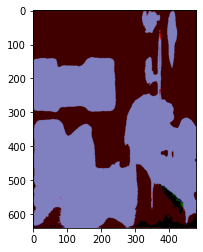

Epoch [1/70], Step [56/3920], Train Loss: 2.73148, Test Loss: 2.19597
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


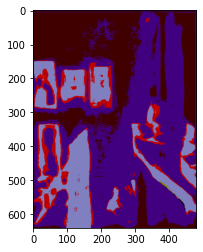

Epoch [2/70], Step [112/3920], Train Loss: 2.18101, Test Loss: 1.96590
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


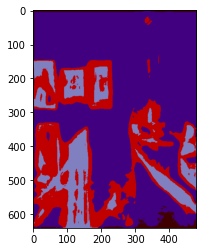

Epoch [3/70], Step [168/3920], Train Loss: 1.98746, Test Loss: 2.15009


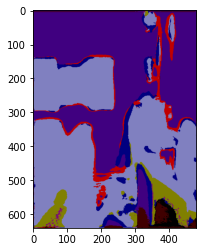

Epoch [4/70], Step [224/3920], Train Loss: 1.91818, Test Loss: 1.74411
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


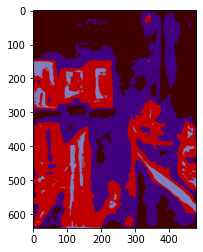

Epoch [5/70], Step [280/3920], Train Loss: 1.83395, Test Loss: 1.91867


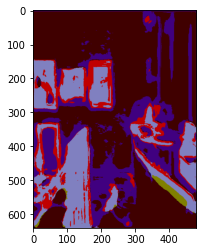

Epoch [6/70], Step [336/3920], Train Loss: 1.75757, Test Loss: 1.83538


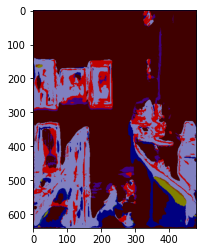

Epoch [7/70], Step [392/3920], Train Loss: 1.65782, Test Loss: 1.67986
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


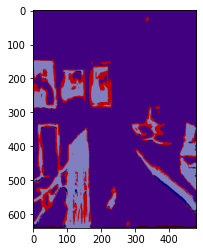

Epoch [8/70], Step [448/3920], Train Loss: 1.68267, Test Loss: 1.54736
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


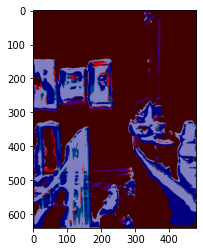

Epoch [9/70], Step [504/3920], Train Loss: 1.59818, Test Loss: 1.51432
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


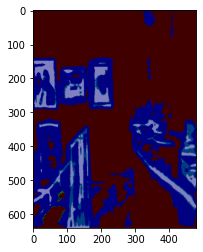

Epoch [10/70], Step [560/3920], Train Loss: 1.57211, Test Loss: 1.53638


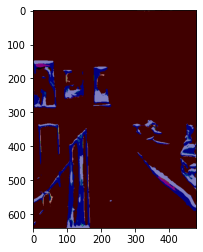

Epoch [11/70], Step [616/3920], Train Loss: 1.48984, Test Loss: 1.13911
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


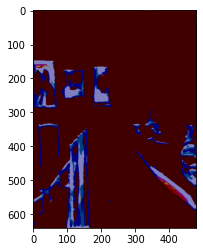

Epoch [12/70], Step [672/3920], Train Loss: 1.42180, Test Loss: 1.33754


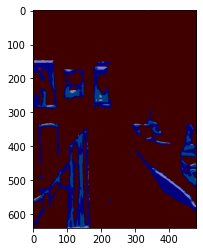

Epoch [13/70], Step [728/3920], Train Loss: 1.43103, Test Loss: 1.26469


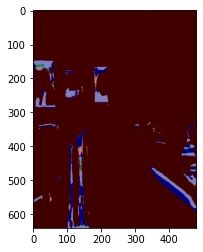

Epoch [14/70], Step [784/3920], Train Loss: 1.40385, Test Loss: 1.13580
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


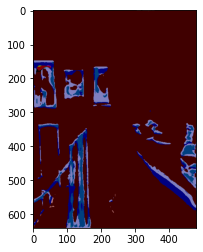

Epoch [15/70], Step [840/3920], Train Loss: 1.34010, Test Loss: 1.32311


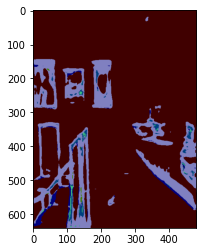

Epoch [16/70], Step [896/3920], Train Loss: 1.35520, Test Loss: 1.35165


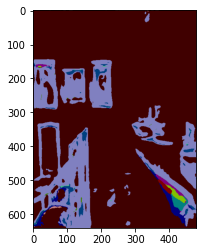

Epoch [17/70], Step [952/3920], Train Loss: 1.31868, Test Loss: 1.46565


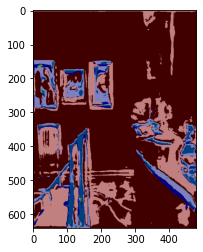

Epoch [18/70], Step [1008/3920], Train Loss: 1.29042, Test Loss: 1.24612


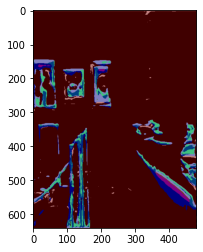

Epoch [19/70], Step [1064/3920], Train Loss: 1.24134, Test Loss: 1.15568


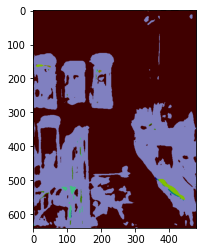

Epoch [20/70], Step [1120/3920], Train Loss: 1.23777, Test Loss: 1.30427


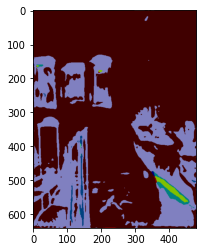

Epoch [21/70], Step [1176/3920], Train Loss: 1.17623, Test Loss: 1.15994


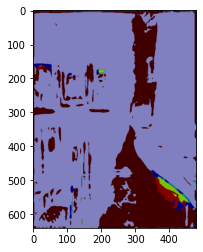

Epoch [22/70], Step [1232/3920], Train Loss: 1.15713, Test Loss: 1.20557


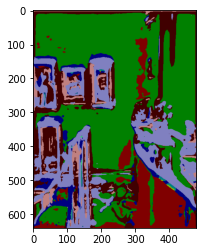

Epoch [23/70], Step [1288/3920], Train Loss: 1.16737, Test Loss: 1.02587
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


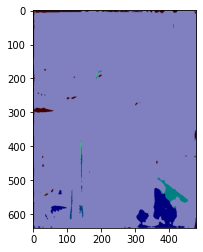

Epoch [24/70], Step [1344/3920], Train Loss: 1.11978, Test Loss: 1.06699


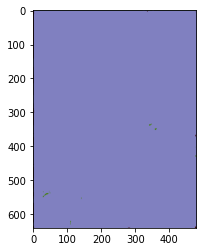

Epoch [25/70], Step [1400/3920], Train Loss: 1.14288, Test Loss: 0.76516
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


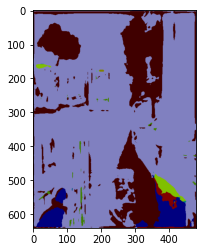

Epoch [26/70], Step [1456/3920], Train Loss: 1.04426, Test Loss: 1.14399


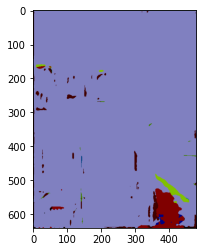

Epoch [27/70], Step [1512/3920], Train Loss: 1.05201, Test Loss: 1.20461


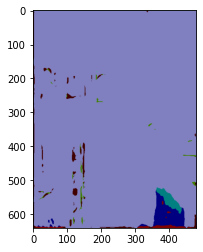

Epoch [28/70], Step [1568/3920], Train Loss: 1.02578, Test Loss: 0.99503


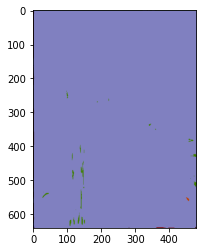

Epoch [29/70], Step [1624/3920], Train Loss: 0.99063, Test Loss: 0.76936


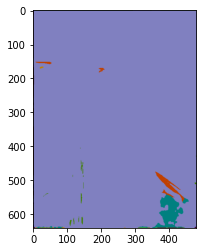

Epoch [30/70], Step [1680/3920], Train Loss: 0.94035, Test Loss: 0.94532


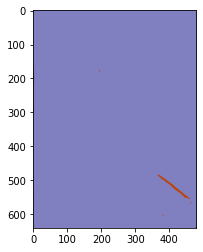

Epoch [31/70], Step [1736/3920], Train Loss: 0.95466, Test Loss: 0.90143


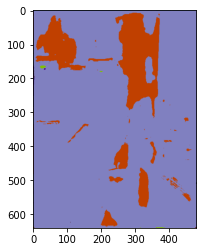

Epoch [32/70], Step [1792/3920], Train Loss: 0.90336, Test Loss: 0.70131
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


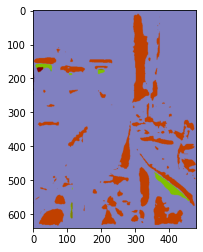

Epoch [33/70], Step [1848/3920], Train Loss: 0.90556, Test Loss: 0.82452


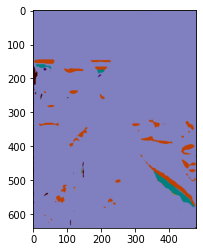

Epoch [34/70], Step [1904/3920], Train Loss: 0.89575, Test Loss: 0.63795
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


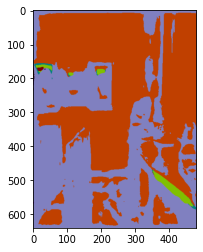

Epoch [35/70], Step [1960/3920], Train Loss: 0.89640, Test Loss: 0.68306


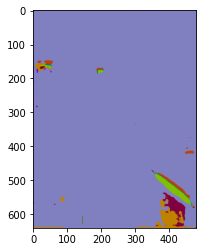

Epoch [36/70], Step [2016/3920], Train Loss: 0.84733, Test Loss: 0.75633


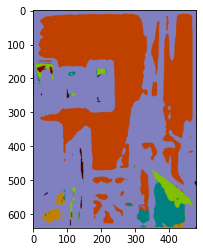

Epoch [37/70], Step [2072/3920], Train Loss: 0.83919, Test Loss: 0.58391
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


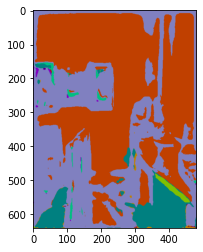

Epoch [38/70], Step [2128/3920], Train Loss: 0.82150, Test Loss: 0.68217


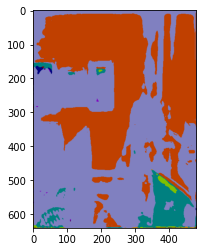

Epoch [39/70], Step [2184/3920], Train Loss: 0.81130, Test Loss: 0.74558


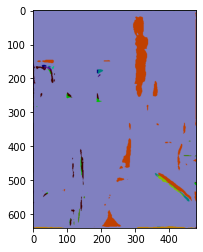

Epoch [40/70], Step [2240/3920], Train Loss: 0.79929, Test Loss: 0.68231


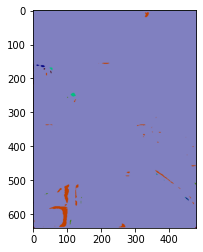

Epoch [41/70], Step [2296/3920], Train Loss: 0.80724, Test Loss: 0.76711


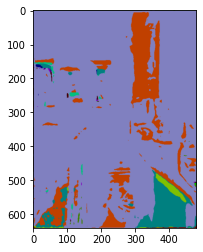

Epoch [42/70], Step [2352/3920], Train Loss: 0.75104, Test Loss: 0.52485
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


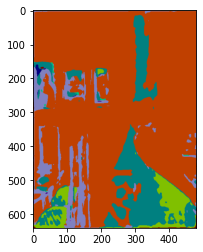

Epoch [43/70], Step [2408/3920], Train Loss: 0.74844, Test Loss: 0.53587


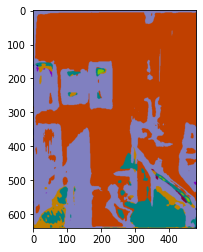

Epoch [44/70], Step [2464/3920], Train Loss: 0.73604, Test Loss: 0.55495


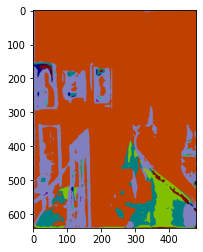

Epoch [45/70], Step [2520/3920], Train Loss: 0.78128, Test Loss: 0.77472


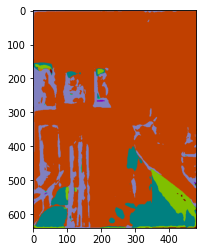

Epoch [46/70], Step [2576/3920], Train Loss: 0.72713, Test Loss: 0.68740


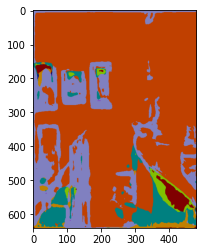

Epoch [47/70], Step [2632/3920], Train Loss: 0.71052, Test Loss: 0.93483


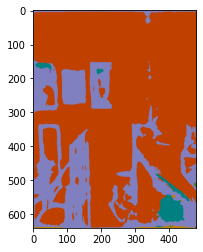

Epoch [48/70], Step [2688/3920], Train Loss: 0.73711, Test Loss: 0.64961


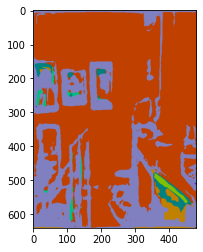

Epoch [49/70], Step [2744/3920], Train Loss: 0.70817, Test Loss: 0.72596


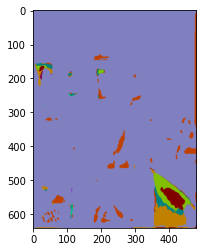

Epoch [50/70], Step [2800/3920], Train Loss: 0.67770, Test Loss: 0.52759


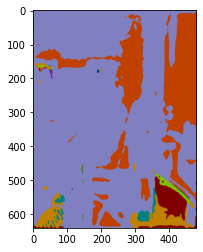

Epoch [51/70], Step [2856/3920], Train Loss: 0.65855, Test Loss: 0.61401


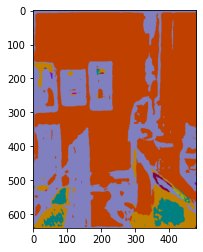

Epoch [52/70], Step [2912/3920], Train Loss: 0.63629, Test Loss: 0.47805
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


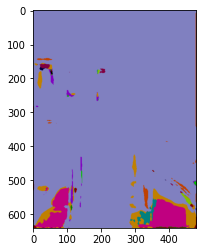

Epoch [53/70], Step [2968/3920], Train Loss: 0.58527, Test Loss: 0.39764
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


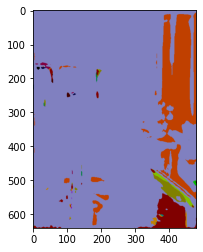

Epoch [54/70], Step [3024/3920], Train Loss: 0.62152, Test Loss: 0.50330


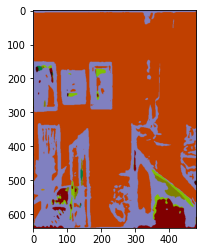

Epoch [55/70], Step [3080/3920], Train Loss: 0.59649, Test Loss: 0.45058


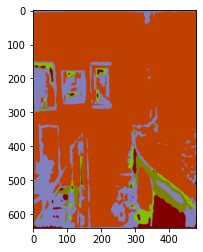

Epoch [56/70], Step [3136/3920], Train Loss: 0.58810, Test Loss: 0.62404


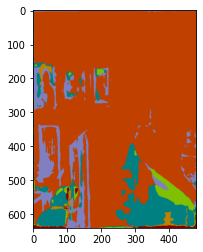

Epoch [57/70], Step [3192/3920], Train Loss: 0.59565, Test Loss: 0.45084


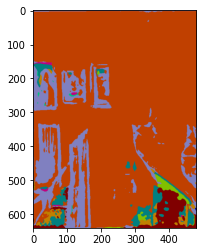

Epoch [58/70], Step [3248/3920], Train Loss: 0.57922, Test Loss: 0.41075


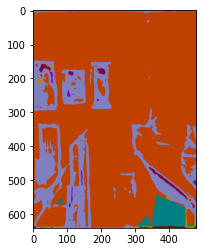

Epoch [59/70], Step [3304/3920], Train Loss: 0.62173, Test Loss: 0.48169


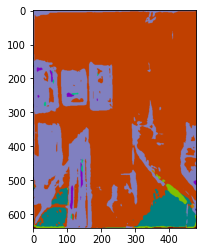

Epoch [60/70], Step [3360/3920], Train Loss: 0.55811, Test Loss: 0.41382


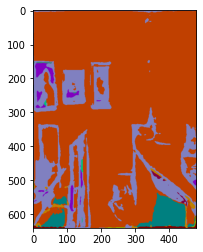

Epoch [61/70], Step [3416/3920], Train Loss: 0.59816, Test Loss: 0.66369


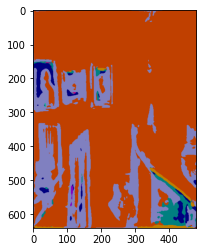

Epoch [62/70], Step [3472/3920], Train Loss: 0.59499, Test Loss: 0.49481


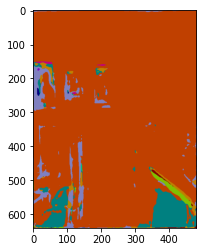

Epoch [63/70], Step [3528/3920], Train Loss: 0.52369, Test Loss: 0.37575
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


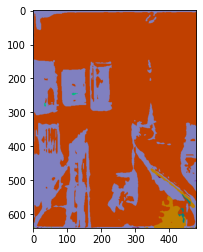

Epoch [64/70], Step [3584/3920], Train Loss: 0.49981, Test Loss: 0.46363


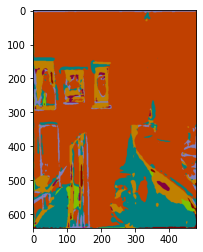

Epoch [65/70], Step [3640/3920], Train Loss: 0.50340, Test Loss: 0.51628


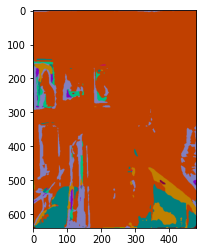

Epoch [66/70], Step [3696/3920], Train Loss: 0.51632, Test Loss: 0.47428


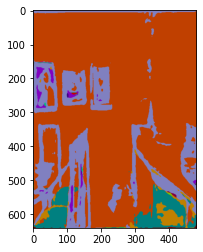

Epoch [67/70], Step [3752/3920], Train Loss: 0.49719, Test Loss: 0.46919


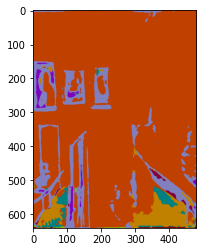

Epoch [68/70], Step [3808/3920], Train Loss: 0.46602, Test Loss: 0.47864


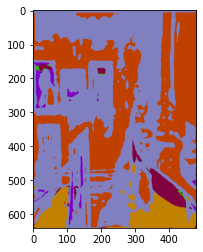

Epoch [69/70], Step [3864/3920], Train Loss: 0.48139, Test Loss: 0.45357


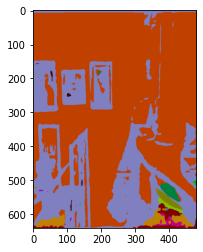

Epoch [70/70], Step [3920/3920], Train Loss: 0.48920, Test Loss: 0.35297
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt
Training finished.


In [15]:
train_segmenter(model, epochs = 70)

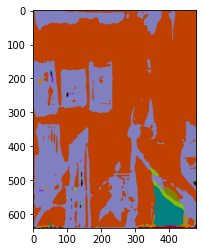

Epoch [1/30], Step [56/1680], Train Loss: 0.51353, Test Loss: 0.44568
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


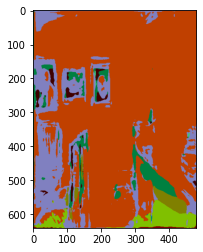

Epoch [2/30], Step [112/1680], Train Loss: 0.55184, Test Loss: 0.54726


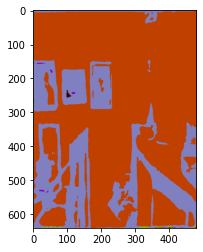

Epoch [3/30], Step [168/1680], Train Loss: 0.50376, Test Loss: 0.35688
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


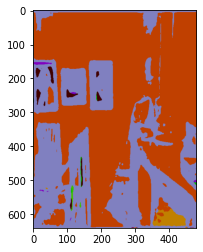

Epoch [4/30], Step [224/1680], Train Loss: 0.47877, Test Loss: 0.32560
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


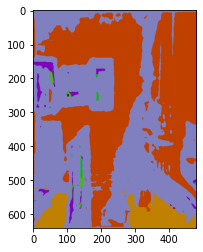

Epoch [5/30], Step [280/1680], Train Loss: 0.44921, Test Loss: 0.30660
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


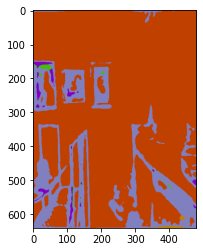

Epoch [6/30], Step [336/1680], Train Loss: 0.43840, Test Loss: 0.27685
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


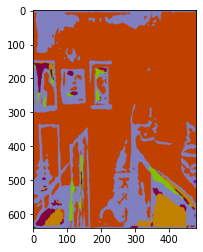

Epoch [7/30], Step [392/1680], Train Loss: 0.44171, Test Loss: 0.36824


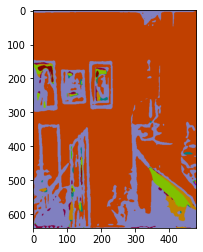

Epoch [8/30], Step [448/1680], Train Loss: 0.43213, Test Loss: 0.26363
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


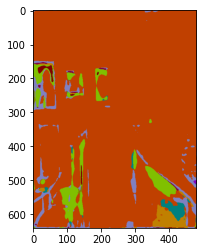

Epoch [9/30], Step [504/1680], Train Loss: 0.40368, Test Loss: 0.38381


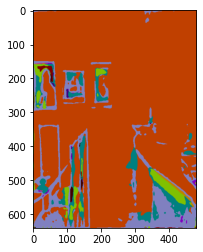

Epoch [10/30], Step [560/1680], Train Loss: 0.42403, Test Loss: 0.58706


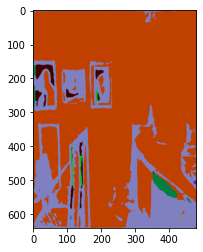

Epoch [11/30], Step [616/1680], Train Loss: 0.45915, Test Loss: 0.34087


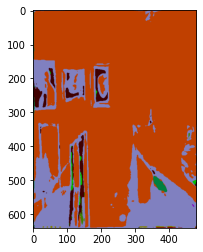

Epoch [12/30], Step [672/1680], Train Loss: 0.45484, Test Loss: 0.33522


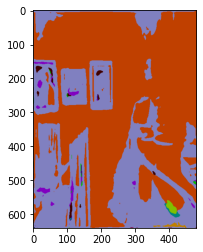

Epoch [13/30], Step [728/1680], Train Loss: 0.43009, Test Loss: 0.38206


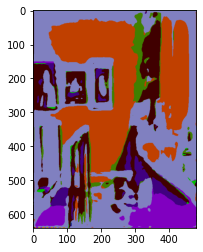

Epoch [14/30], Step [784/1680], Train Loss: 0.48138, Test Loss: 0.51998


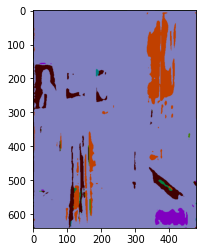

Epoch [15/30], Step [840/1680], Train Loss: 0.49765, Test Loss: 0.41296


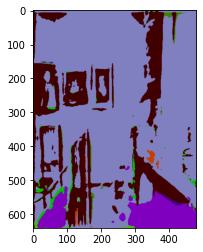

Epoch [16/30], Step [896/1680], Train Loss: 0.44785, Test Loss: 0.37652


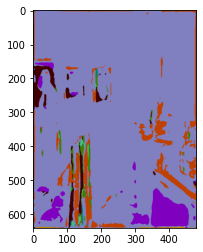

Epoch [17/30], Step [952/1680], Train Loss: 0.40601, Test Loss: 0.31725


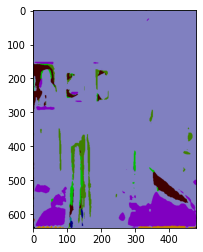

Epoch [18/30], Step [1008/1680], Train Loss: 0.40415, Test Loss: 0.36169


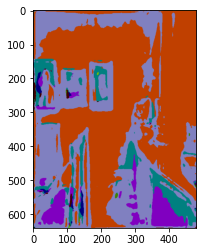

Epoch [19/30], Step [1064/1680], Train Loss: 0.43181, Test Loss: 0.33579


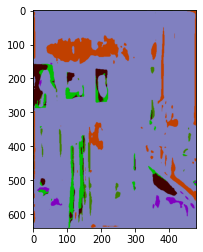

Epoch [20/30], Step [1120/1680], Train Loss: 0.39881, Test Loss: 0.36679


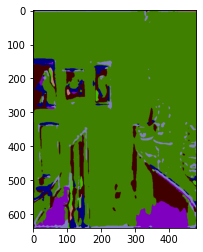

Epoch [21/30], Step [1176/1680], Train Loss: 0.40035, Test Loss: 0.34552


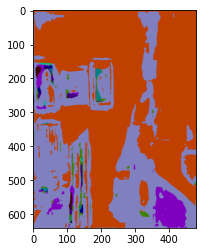

Epoch [22/30], Step [1232/1680], Train Loss: 0.38841, Test Loss: 0.32541


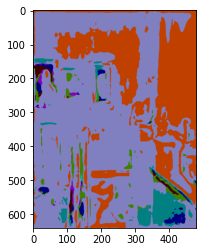

Epoch [23/30], Step [1288/1680], Train Loss: 0.36370, Test Loss: 0.29986


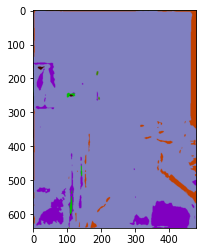

Epoch [24/30], Step [1344/1680], Train Loss: 0.37821, Test Loss: 0.42646


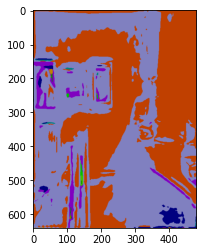

Epoch [25/30], Step [1400/1680], Train Loss: 0.53893, Test Loss: 0.42490


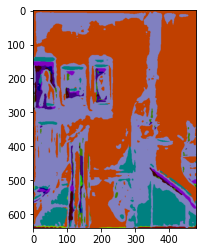

Epoch [26/30], Step [1456/1680], Train Loss: 0.49910, Test Loss: 0.32735


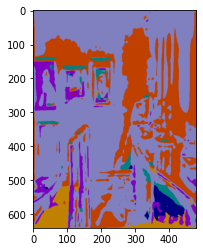

Epoch [27/30], Step [1512/1680], Train Loss: 0.45001, Test Loss: 0.38031


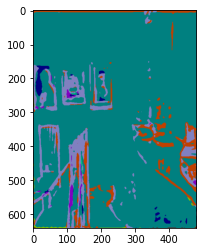

Epoch [28/30], Step [1568/1680], Train Loss: 0.42481, Test Loss: 0.25178
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


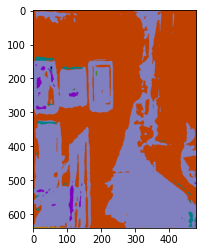

Epoch [29/30], Step [1624/1680], Train Loss: 0.36469, Test Loss: 0.27071


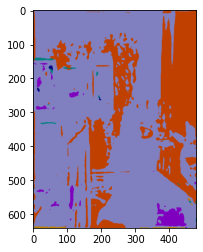

Epoch [30/30], Step [1680/1680], Train Loss: 0.36265, Test Loss: 0.29687
Training finished.


In [16]:
train_segmenter(model, epochs = 30)

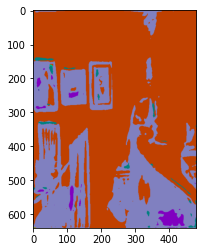

Epoch [1/10], Step [56/560], Train Loss: 0.31131, Test Loss: 0.25124
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


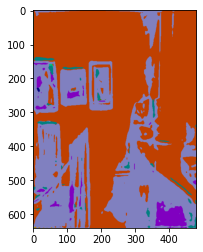

Epoch [2/10], Step [112/560], Train Loss: 0.28931, Test Loss: 0.22942
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


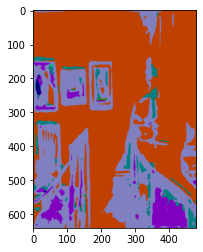

Epoch [3/10], Step [168/560], Train Loss: 0.28424, Test Loss: 0.24823


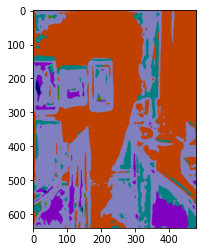

Epoch [4/10], Step [224/560], Train Loss: 0.27585, Test Loss: 0.23335


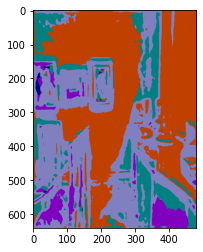

Epoch [5/10], Step [280/560], Train Loss: 0.26564, Test Loss: 0.25929


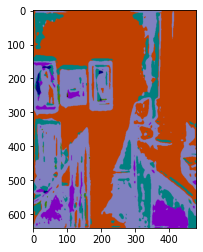

Epoch [6/10], Step [336/560], Train Loss: 0.26252, Test Loss: 0.25161


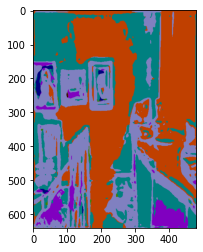

Epoch [7/10], Step [392/560], Train Loss: 0.27036, Test Loss: 0.28397


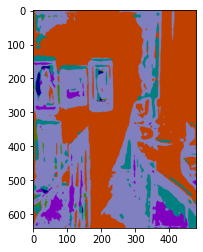

Epoch [8/10], Step [448/560], Train Loss: 0.25457, Test Loss: 0.26390


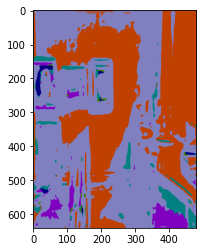

Epoch [9/10], Step [504/560], Train Loss: 0.26038, Test Loss: 0.32127


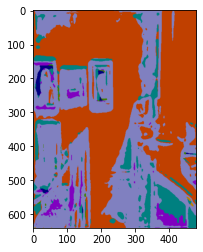

Epoch [10/10], Step [560/560], Train Loss: 0.25666, Test Loss: 0.19302
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt
Training finished.


In [28]:
train_segmenter(model, learning_rate = 0.0001, epochs = 10)

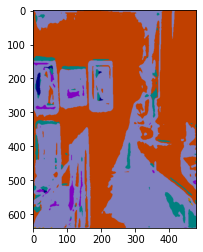

Epoch [1/10], Step [56/560], Train Loss: 0.25364, Test Loss: 0.20637
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


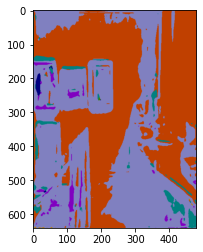

Epoch [2/10], Step [112/560], Train Loss: 0.25439, Test Loss: 0.29209


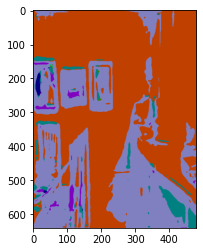

Epoch [3/10], Step [168/560], Train Loss: 0.24482, Test Loss: 0.17922
Metrics saved to ==> seg_metrics.pt
Model saved to ==> seg_model.pt


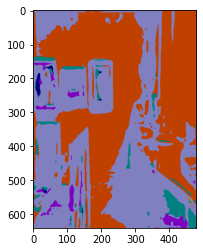

Epoch [4/10], Step [224/560], Train Loss: 0.24962, Test Loss: 0.24543


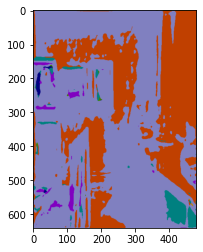

Epoch [5/10], Step [280/560], Train Loss: 0.24473, Test Loss: 0.27000


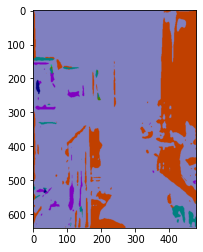

Epoch [6/10], Step [336/560], Train Loss: 0.24199, Test Loss: 0.21582


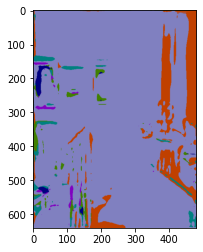

Epoch [7/10], Step [392/560], Train Loss: 0.23739, Test Loss: 0.25836


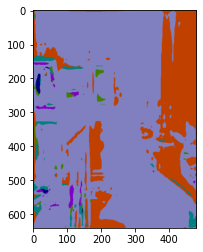

Epoch [8/10], Step [448/560], Train Loss: 0.23566, Test Loss: 0.21116


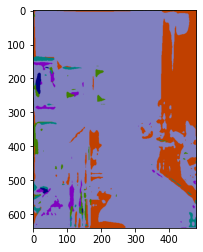

Epoch [9/10], Step [504/560], Train Loss: 0.23877, Test Loss: 0.20820


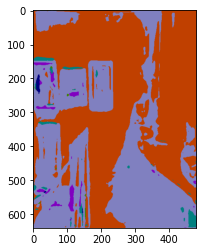

Epoch [10/10], Step [560/560], Train Loss: 0.23374, Test Loss: 0.22839
Training finished.


In [29]:
train_segmenter(model, learning_rate = 0.0001, epochs = 10)

In [ ]:
train_segmenter(model, learning_rate = 0.01, epochs = 30, save_path_metrics = 'seg_metrics_try.pt',
                    save_path_model = 'seg_model_try.pt')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_004-0db870e6.pth" to /root/.cache/torch/hub/checkpoints/regnety_004-0db870e6.pth


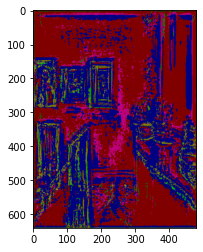

Epoch [1/25], Step [56/1400], Train Loss: 3.39010, Test Loss: 2.97796
Metrics saved to ==> seg_metrics_try2.pt
Model saved to ==> seg_model_try2.pt


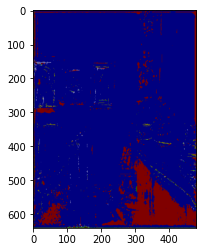

Epoch [2/25], Step [112/1400], Train Loss: 2.85431, Test Loss: 2.67070
Metrics saved to ==> seg_metrics_try2.pt
Model saved to ==> seg_model_try2.pt


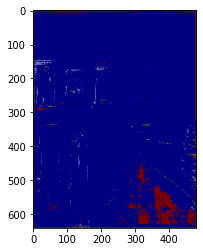

Epoch [3/25], Step [168/1400], Train Loss: 2.48578, Test Loss: 2.19994
Metrics saved to ==> seg_metrics_try2.pt
Model saved to ==> seg_model_try2.pt


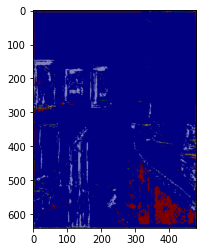

Epoch [4/25], Step [224/1400], Train Loss: 2.28722, Test Loss: 2.58741


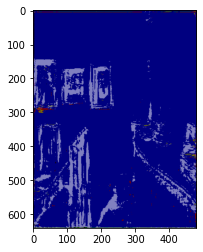

Epoch [5/25], Step [280/1400], Train Loss: 2.13890, Test Loss: 2.02177
Metrics saved to ==> seg_metrics_try2.pt
Model saved to ==> seg_model_try2.pt


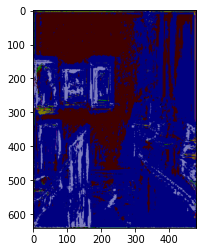

Epoch [6/25], Step [336/1400], Train Loss: 2.02745, Test Loss: 1.59010
Metrics saved to ==> seg_metrics_try2.pt
Model saved to ==> seg_model_try2.pt


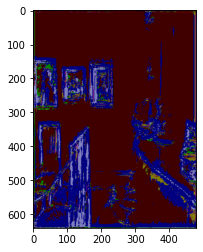

Epoch [7/25], Step [392/1400], Train Loss: 1.91812, Test Loss: 1.65214


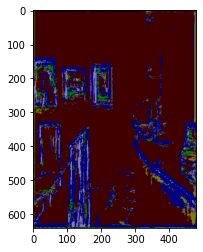

Epoch [8/25], Step [448/1400], Train Loss: 1.83377, Test Loss: 1.81761


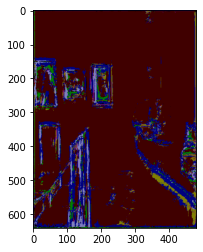

Epoch [9/25], Step [504/1400], Train Loss: 1.76167, Test Loss: 1.45310
Metrics saved to ==> seg_metrics_try2.pt
Model saved to ==> seg_model_try2.pt


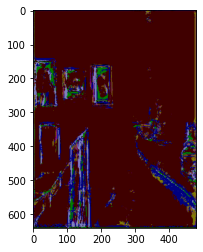

Epoch [10/25], Step [560/1400], Train Loss: 1.69308, Test Loss: 1.60038


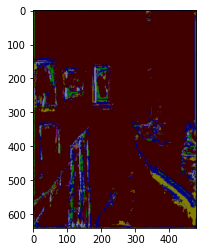

Epoch [11/25], Step [616/1400], Train Loss: 1.65795, Test Loss: 1.67347


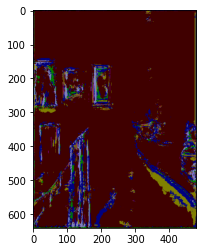

Epoch [12/25], Step [672/1400], Train Loss: 1.60300, Test Loss: 1.48473


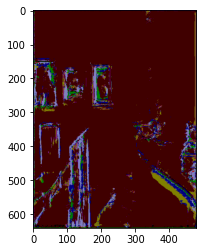

Epoch [13/25], Step [728/1400], Train Loss: 1.54866, Test Loss: 1.39616
Metrics saved to ==> seg_metrics_try2.pt
Model saved to ==> seg_model_try2.pt


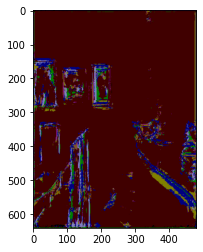

Epoch [14/25], Step [784/1400], Train Loss: 1.51551, Test Loss: 1.46241


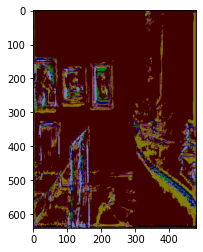

Epoch [15/25], Step [840/1400], Train Loss: 1.46036, Test Loss: 1.40372


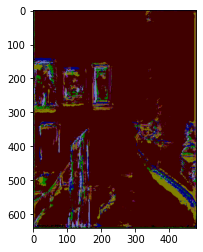

Epoch [16/25], Step [896/1400], Train Loss: 1.43658, Test Loss: 1.53409


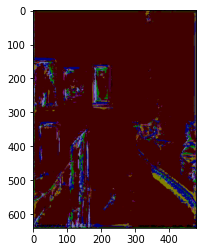

Epoch [17/25], Step [952/1400], Train Loss: 1.36488, Test Loss: 1.17201
Metrics saved to ==> seg_metrics_try2.pt
Model saved to ==> seg_model_try2.pt


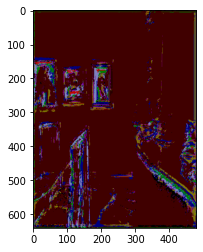

Epoch [18/25], Step [1008/1400], Train Loss: 1.36105, Test Loss: 1.24464


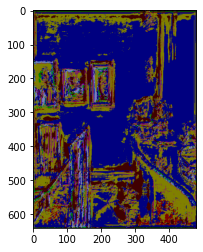

Epoch [19/25], Step [1064/1400], Train Loss: 1.34695, Test Loss: 1.07470
Metrics saved to ==> seg_metrics_try2.pt
Model saved to ==> seg_model_try2.pt


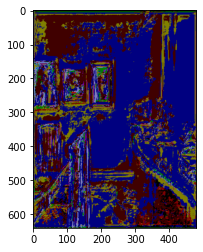

Epoch [20/25], Step [1120/1400], Train Loss: 1.30754, Test Loss: 0.94780
Metrics saved to ==> seg_metrics_try2.pt
Model saved to ==> seg_model_try2.pt


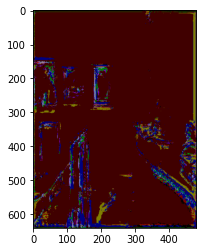

Epoch [21/25], Step [1176/1400], Train Loss: 1.24133, Test Loss: 0.93630
Metrics saved to ==> seg_metrics_try2.pt
Model saved to ==> seg_model_try2.pt


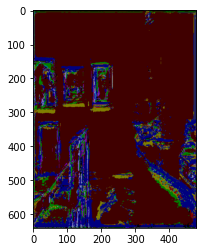

Epoch [22/25], Step [1232/1400], Train Loss: 1.22548, Test Loss: 1.14948


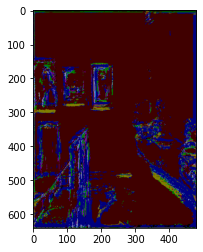

Epoch [23/25], Step [1288/1400], Train Loss: 1.19776, Test Loss: 1.11732


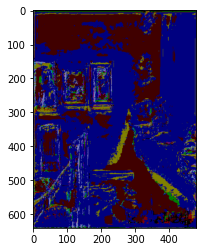

Epoch [24/25], Step [1344/1400], Train Loss: 1.16380, Test Loss: 1.17902


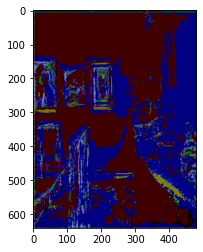

Epoch [25/25], Step [1400/1400], Train Loss: 1.13181, Test Loss: 0.92840
Metrics saved to ==> seg_metrics_try2.pt
Model saved to ==> seg_model_try2.pt
Training finished.


In [14]:
model = smp.Unet(encoder_name="timm-regnety_004", 
                encoder_weights="imagenet",
                in_channels=3,                  
                classes=40
                )
model.cuda()
train_segmenter(model, learning_rate = 0.0001, epochs = 25, save_path_metrics = 'seg_metrics_try2.pt',
                    save_path_model = 'seg_model_try2.pt')

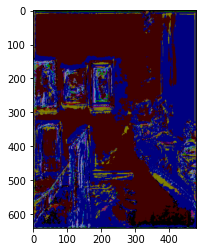

Epoch [1/25], Step [56/1400], Train Loss: 1.10477, Test Loss: 1.00590
Metrics saved to ==> seg_metrics_try22.pt
Model saved to ==> seg_model_try22.pt


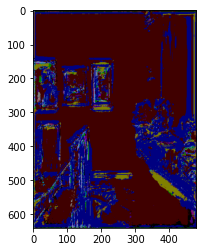

Epoch [2/25], Step [112/1400], Train Loss: 1.05760, Test Loss: 0.95436
Metrics saved to ==> seg_metrics_try22.pt
Model saved to ==> seg_model_try22.pt


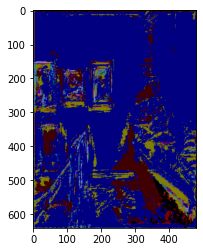

Epoch [3/25], Step [168/1400], Train Loss: 1.02768, Test Loss: 0.77036
Metrics saved to ==> seg_metrics_try22.pt
Model saved to ==> seg_model_try22.pt


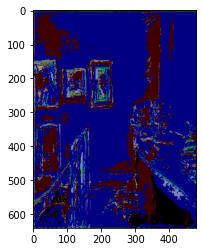

Epoch [4/25], Step [224/1400], Train Loss: 1.00468, Test Loss: 0.79243


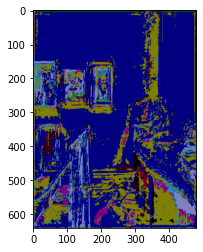

Epoch [5/25], Step [280/1400], Train Loss: 0.99163, Test Loss: 0.89756


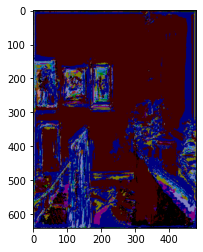

Epoch [6/25], Step [336/1400], Train Loss: 0.97375, Test Loss: 0.76716
Metrics saved to ==> seg_metrics_try22.pt
Model saved to ==> seg_model_try22.pt


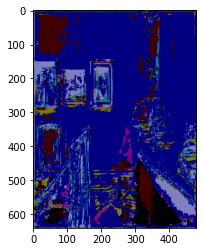

Epoch [7/25], Step [392/1400], Train Loss: 0.94603, Test Loss: 0.95390


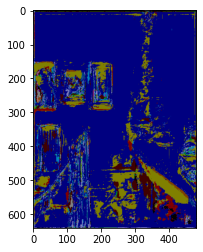

Epoch [8/25], Step [448/1400], Train Loss: 0.91123, Test Loss: 0.78670


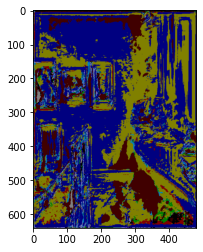

Epoch [9/25], Step [504/1400], Train Loss: 0.89948, Test Loss: 0.93153


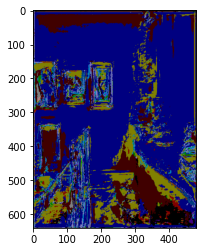

Epoch [10/25], Step [560/1400], Train Loss: 0.87067, Test Loss: 0.97650


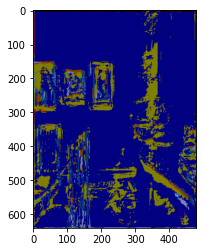

Epoch [11/25], Step [616/1400], Train Loss: 0.86971, Test Loss: 0.75800
Metrics saved to ==> seg_metrics_try22.pt
Model saved to ==> seg_model_try22.pt


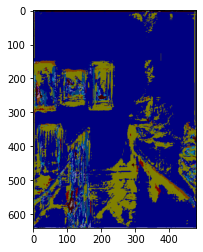

Epoch [12/25], Step [672/1400], Train Loss: 0.84056, Test Loss: 0.71057
Metrics saved to ==> seg_metrics_try22.pt
Model saved to ==> seg_model_try22.pt


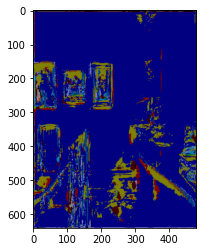

Epoch [13/25], Step [728/1400], Train Loss: 0.82055, Test Loss: 0.77017


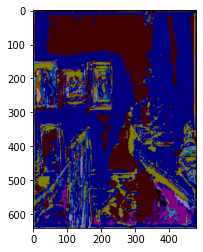

Epoch [14/25], Step [784/1400], Train Loss: 0.82225, Test Loss: 0.71641


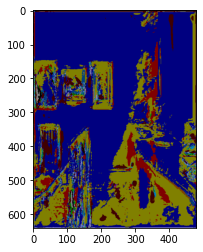

Epoch [15/25], Step [840/1400], Train Loss: 0.80287, Test Loss: 0.60355
Metrics saved to ==> seg_metrics_try22.pt
Model saved to ==> seg_model_try22.pt


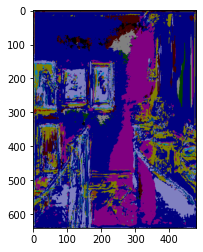

Epoch [16/25], Step [896/1400], Train Loss: 0.79892, Test Loss: 0.79246


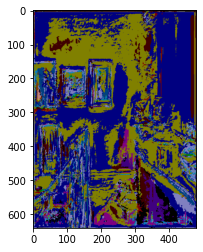

Epoch [17/25], Step [952/1400], Train Loss: 0.75620, Test Loss: 0.47867
Metrics saved to ==> seg_metrics_try22.pt
Model saved to ==> seg_model_try22.pt


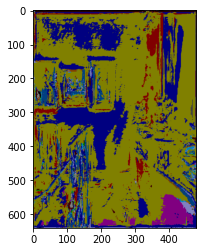

Epoch [18/25], Step [1008/1400], Train Loss: 0.74000, Test Loss: 0.67360


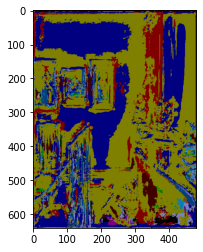

Epoch [19/25], Step [1064/1400], Train Loss: 0.73263, Test Loss: 0.75765


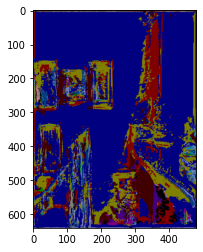

Epoch [20/25], Step [1120/1400], Train Loss: 0.72235, Test Loss: 0.62636


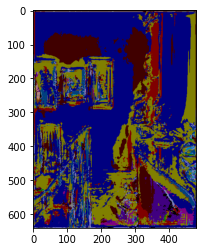

Epoch [21/25], Step [1176/1400], Train Loss: 0.69517, Test Loss: 0.57824


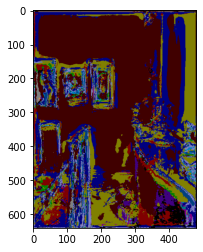

Epoch [22/25], Step [1232/1400], Train Loss: 0.70164, Test Loss: 0.58727


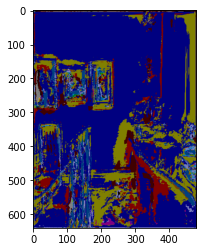

Epoch [23/25], Step [1288/1400], Train Loss: 0.68510, Test Loss: 0.59734


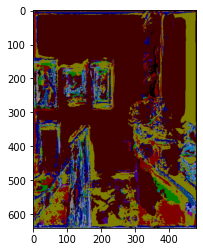

Epoch [24/25], Step [1344/1400], Train Loss: 0.65774, Test Loss: 0.50065


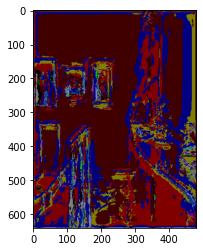

Epoch [25/25], Step [1400/1400], Train Loss: 0.66051, Test Loss: 0.46611
Metrics saved to ==> seg_metrics_try22.pt
Model saved to ==> seg_model_try22.pt
Training finished.


In [15]:
train_segmenter(model, learning_rate = 0.0001, epochs = 25, save_path_metrics = 'seg_metrics_try22.pt',
                    save_path_model = 'seg_model_try22.pt')

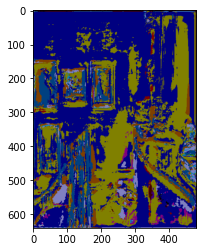

Epoch [1/10], Step [56/560], Train Loss: 0.66352, Test Loss: 0.57532
Metrics saved to ==> seg_metrics_try222.pt
Model saved to ==> seg_model_try222.pt


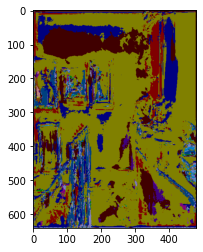

Epoch [2/10], Step [112/560], Train Loss: 0.63116, Test Loss: 0.62810


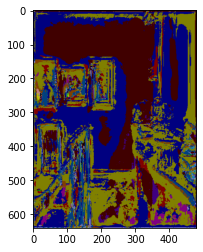

Epoch [3/10], Step [168/560], Train Loss: 0.61025, Test Loss: 0.51190
Metrics saved to ==> seg_metrics_try222.pt
Model saved to ==> seg_model_try222.pt


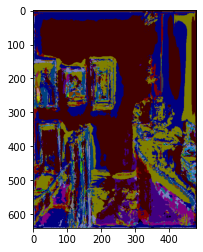

Epoch [4/10], Step [224/560], Train Loss: 0.62725, Test Loss: 0.44495
Metrics saved to ==> seg_metrics_try222.pt
Model saved to ==> seg_model_try222.pt


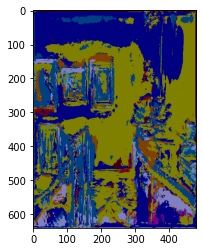

Epoch [5/10], Step [280/560], Train Loss: 0.61160, Test Loss: 0.66009


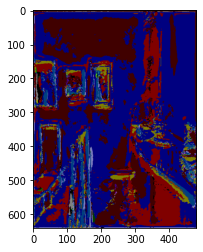

Epoch [6/10], Step [336/560], Train Loss: 0.59368, Test Loss: 0.54668


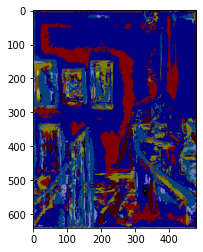

Epoch [7/10], Step [392/560], Train Loss: 0.58010, Test Loss: 0.64668


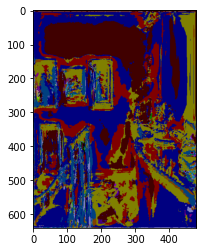

Epoch [8/10], Step [448/560], Train Loss: 0.56537, Test Loss: 0.45997


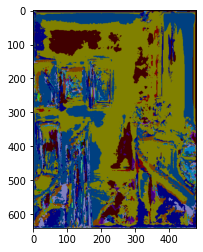

Epoch [9/10], Step [504/560], Train Loss: 0.56528, Test Loss: 0.41348
Metrics saved to ==> seg_metrics_try222.pt
Model saved to ==> seg_model_try222.pt


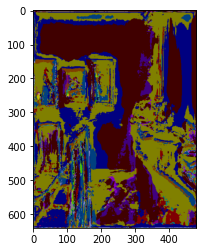

Epoch [10/10], Step [560/560], Train Loss: 0.55905, Test Loss: 0.43815
Training finished.


In [17]:
train_segmenter(model, learning_rate = 0.0001, epochs = 10, save_path_metrics = 'seg_metrics_try222.pt',
                    save_path_model = 'seg_model_try222.pt')

In [ ]:
model = smp.Unet(encoder_name="timm-regnety_004", 
                encoder_weights="imagenet",
                in_channels=3,                  
                classes=40
                )
model.cuda()
train_segmenter(model, learning_rate = 0.001, epochs = 40, save_path_metrics = 'seg_metrics_try3.pt',
                    save_path_model = 'seg_model_try3.pt')

In [ ]:
model = smp.Unet(encoder_name="timm-regnety_004", 
                encoder_weights="imagenet",
                in_channels=3,                  
                classes=40
                )
model.cuda()
train_segmenter(model, learning_rate = 0.001, epochs = 20, save_path_metrics = 'seg_metrics_try4.pt',
                    save_path_model = 'seg_model_try4.pt')

In [ ]:
model = smp.Unet(encoder_name="timm-regnety_004", 
                encoder_weights="imagenet",
                in_channels=3,                  
                classes=40
                )
model.cuda()
train_segmenter(model, learning_rate = 0.01, epochs = 10, save_path_metrics = 'seg_metrics_try5.pt',
                    save_path_model = 'seg_model_try5.pt')

Epoch [1/5], Step [49/245], Train Loss: 0.56631, Test Loss: 0.44918
Metrics saved to ==> seg_metrics3.pt
Model saved to ==> seg_model3.pt
Epoch [2/5], Step [98/245], Train Loss: 0.54417, Test Loss: 0.57940
Epoch [3/5], Step [147/245], Train Loss: 0.53146, Test Loss: 0.47593
Epoch [4/5], Step [196/245], Train Loss: 0.51841, Test Loss: 0.53414
Epoch [5/5], Step [245/245], Train Loss: 0.52226, Test Loss: 0.44477
Metrics saved to ==> seg_metrics3.pt
Model saved to ==> seg_model3.pt
Training finished.


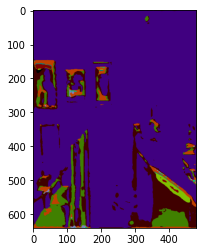

In [34]:
train_segmenter(model, learning_rate = 0.0001, epochs = 5, save_path_metrics = 'seg_metrics3.pt',
                    save_path_model = 'seg_model3.pt')

Epoch [1/10], Step [49/490], Train Loss: 0.50193, Test Loss: 0.60778
Metrics saved to ==> seg_metrics4.pt
Model saved to ==> seg_model4.pt
Epoch [2/10], Step [98/490], Train Loss: 0.50094, Test Loss: 0.51914
Metrics saved to ==> seg_metrics4.pt
Model saved to ==> seg_model4.pt
Epoch [3/10], Step [147/490], Train Loss: 0.50148, Test Loss: 0.45513
Metrics saved to ==> seg_metrics4.pt
Model saved to ==> seg_model4.pt
Epoch [4/10], Step [196/490], Train Loss: 0.50567, Test Loss: 0.38291
Metrics saved to ==> seg_metrics4.pt
Model saved to ==> seg_model4.pt
Epoch [5/10], Step [245/490], Train Loss: 0.49826, Test Loss: 0.45528
Epoch [6/10], Step [294/490], Train Loss: 0.49461, Test Loss: 0.40355
Epoch [7/10], Step [343/490], Train Loss: 0.49300, Test Loss: 0.62708
Epoch [8/10], Step [392/490], Train Loss: 0.49221, Test Loss: 0.49972
Epoch [9/10], Step [441/490], Train Loss: 0.49048, Test Loss: 0.50888
Epoch [10/10], Step [490/490], Train Loss: 0.50333, Test Loss: 0.46586
Training finished.


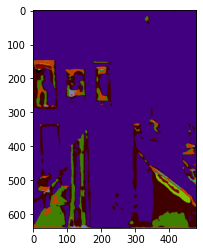

In [38]:
train_segmenter(model, learning_rate = 0.00001, epochs = 10, save_path_metrics = 'seg_metrics4.pt',
                    save_path_model = 'seg_model4.pt')

In [48]:
#image = Image.open(f'data/train_images/001440.png')
image = Image.open(f'/content/gdrive/MyDrive/Diploma/test2.jpg')

In [35]:
import matplotlib.pyplot as plt



In [ ]:
dictt = torch.load('/content/gdrive/MyDrive/Diploma/Models/seg_model_130ep.pt')
model.load_state_dict(dictt['model_state_dict'] )
model.eval()

In [46]:
def my_predict_segmentaion(model, image, num_classes=40):
  cmap = np.load('light-weight-refinenet/utils/cmap.npy')
  image = image.resize((480, 640))
  plt.imshow(image)
  plt.show()
  image = np.expand_dims(np.array(image), axis=-1)
  image = image.transpose((3, 2, 0, 1))
  image = torch.from_numpy(image).float()
  image = image.cuda()
  with torch.no_grad():
    segm = model(image)[0].data.cpu().numpy().transpose(1, 2, 0)
    segm = cv2.resize(segm, (480, 640), interpolation=cv2.INTER_CUBIC)
    segm = cmap[segm.argmax(axis=2).astype(np.uint8)]
    plt.imshow(segm)
    plt.show()
    

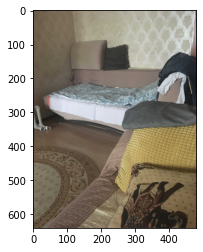

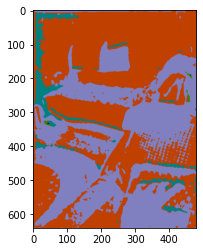

In [49]:
my_predict_segmentaion(model, image)

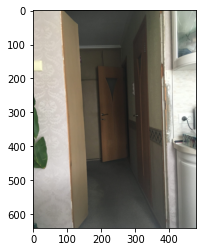

In [41]:
my_predict_segmentaion(model, image)

In [110]:
def validate(segmenter, val_loader, epoch, num_classes=-1):
    """Validate segmenter
    Args:
      segmenter (nn.Module) : segmentation network
      val_loader (DataLoader) : training data iterator
      epoch (int) : current epoch
      num_classes (int) : number of classes to consider
    Returns:
      Mean IoU (float)
    """
    
    segmenter.eval()
    val_loader.dataset.set_stage("val")
    cm = np.zeros((num_classes, num_classes), dtype=int)
    with torch.no_grad():
        for i, sample in enumerate(val_loader):
            input = sample["image"].cuda()
            target = sample["mask"].cuda()
            input_var = torch.autograd.Variable(input).float().cuda()
            # Compute output
            print(input_var.size())
            output = segmenter(input_var)
            output = (
                cv2.resize(
                    output[0, :num_classes].data.cpu().numpy().transpose(1, 2, 0),
                    target.size()[1:][::-1],
                    interpolation=cv2.INTER_CUBIC,
                )
                .argmax(axis=2)
                .astype(np.uint8)
            )
            # Compute IoU
            gt = target[0].data.cpu().numpy().astype(np.uint8)
            gt_idx = (
                gt < num_classes
            )  # Ignore every class index larger than the number of classes
            cm += fast_cm(output[gt_idx], gt[gt_idx], num_classes)

            print(
                    " Val epoch: {} [{}/{}]\t"
                    "Mean IoU: {:.3f}".format(
                        epoch, i, len(val_loader), compute_iu(cm).mean()
                    )
                )

    ious = compute_iu(cm)
    print(" IoUs: {}".format(ious))
    miou = np.mean(ious)
    print(" Val epoch: {}\tMean IoU: {:.3f}".format(epoch, miou))
    return miou

In [111]:
validate(model, val_loader, 10, num_classes=40)

torch.Size([1, 3, 468, 625])


RuntimeError: ignored